## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load the country-day dataset (main ML dataset)
DATA_PATH = Path(r"C:\Users\Emman\Documents\AI_dev\GDELT_ConflictPredictor\data\features_multiresolution")

df = pd.read_parquet(DATA_PATH / "country_day" / "country_day_features.parquet")
print(f"Dataset loaded: {len(df):,} observations, {len(df.columns)} features")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Countries: {df['Country'].nunique()}")
df.head()

Dataset loaded: 220,301 observations, 55 features
Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00
Countries: 223


,Country,Date,EventCount,IsCooperation_sum,IsCooperation_mean,IsVerbalCoop_sum,IsVerbalCoop_mean,IsMaterialCoop_sum,IsMaterialCoop_mean,IsHighConflict_sum,...,ActionGeo_Long_std,HasCoordinates_sum,HasCoordinates_mean,AvgTone_mean,AvgTone_std,UniqueRegions,UniqueLocations,UniqueActor1,UniqueActor2,UniqueEventTypes
0,ABW,2023-01-01,2,2,1.000000,2,1.000000,0,0.000000,0,...,0.000000,2,1.000000,-2.977510,8.645651,1,1,1,0,2
1,AFG,2023-01-01,297,212,0.713805,181,0.609428,31,0.104377,58,...,40.704990,294,0.989899,-4.123662,2.613348,47,55,6,62,54
2,AFR,2023-01-01,230,180,0.782609,165,0.717391,15,0.065217,31,...,43.323314,226,0.982609,-0.919620,4.303265,73,93,4,65,42
3,AGO,2023-01-01,3,1,0.333333,1,0.333333,0,0.000000,0,...,6.674516,3,1.000000,-5.208737,1.947008,2,2,2,2,2
4,ARE,2023-01-01,114,78,0.684211,66,0.578947,12,0.105263,15,...,48.584642,110,0.964912,0.174284,5.934628,27,31,4,37,33


In [3]:
# Quick data overview
print("📊 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes.value_counts())
print(f"\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False).head(10))

📊 Dataset Info:
Shape: (220301, 55)

Column types:
float64           29
int64             24
datetime64[ns]     1
object             1
Name: count, dtype: int64

Missing values:
ActionGeo_Lat_std      20641
ActionGeo_Long_std     20615
GoldsteinScale_std     19722
AvgTone_std            19722
IntensityScore_std     19722
ActionGeo_Lat_mean      1254
ActionGeo_Long_mean     1225
dtype: int64


## 2. Feature Engineering & Target Definition

In [4]:
# Define prediction targets
# We'll test multiple prediction tasks:

# 1. CLASSIFICATION: Will tomorrow have high conflict? (binary)
# 2. REGRESSION: Predict tomorrow's conflict count
# 3. CLASSIFICATION: Will conflict escalate? (increase from today)

# Prepare data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Country', 'Date'])

# Get conflict column name
conflict_col = 'IsHighConflict_sum' if 'IsHighConflict_sum' in df.columns else 'ConflictCount_Day'
print(f"Using conflict column: {conflict_col}")

# Create target variables (NEXT DAY prediction)
df['NextDay_Conflict'] = df.groupby('Country')[conflict_col].shift(-1)
df['NextDay_HighConflict'] = (df['NextDay_Conflict'] >= df['NextDay_Conflict'].quantile(0.75)).astype(int)
df['Conflict_Escalation'] = (df['NextDay_Conflict'] > df[conflict_col]).astype(int)

# Drop rows with NaN targets (last day for each country)
df_ml = df.dropna(subset=['NextDay_Conflict', 'NextDay_HighConflict'])

print(f"\nML dataset: {len(df_ml):,} observations")
print(f"\nTarget distribution:")
print(f"  High Conflict (binary): {df_ml['NextDay_HighConflict'].mean()*100:.1f}% positive")
print(f"  Escalation: {df_ml['Conflict_Escalation'].mean()*100:.1f}% escalating")

Using conflict column: IsHighConflict_sum



ML dataset: 220,078 observations

Target distribution:
  High Conflict (binary): 25.0% positive
  Escalation: 41.8% escalating


In [5]:
# Select features for modeling
# Exclude identifiers and target columns
exclude_cols = ['Country', 'Date', 'NextDay_Conflict', 'NextDay_HighConflict', 
                'Conflict_Escalation', 'TopRegion']

feature_cols = [col for col in df_ml.columns if col not in exclude_cols 
                and df_ml[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Features selected: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Features selected: 53

Feature list:
   1. EventCount
   2. IsCooperation_sum
   3. IsCooperation_mean
   4. IsVerbalCoop_sum
   5. IsVerbalCoop_mean
   6. IsMaterialCoop_sum
   7. IsMaterialCoop_mean
   8. IsHighConflict_sum
   9. IsHighConflict_mean
  10. IsVerbalConflict_sum
  11. IsVerbalConflict_mean
  12. IsMaterialConflict_sum
  13. IsMaterialConflict_mean
  14. GoldsteinScale_mean
  15. GoldsteinScale_std
  16. GoldsteinScale_min
  17. GoldsteinScale_max
  18. IntensityScore_mean
  19. IntensityScore_std
  20. IntensityScore_min
  21. IntensityScore_max
  22. IsHighIntensity_sum
  23. IsHighIntensity_mean
  24. IsPositiveEvent_sum
  25. IsPositiveEvent_mean
  26. IsNegativeEvent_sum
  27. IsNegativeEvent_mean
  28. IsCrossBorder_sum
  29. IsCrossBorder_mean
  30. IsDomestic_sum
  31. IsDomestic_mean
  32. NumMentions_sum
  33. NumMentions_mean
  34. NumMentions_max
  35. NumSources_sum
  36. NumSources_mean
  37. NumSources_max
  38. NumArticles_sum
  39. NumArticles_mean
  40.

In [6]:
# Prepare feature matrix and handle missing values
X = df_ml[feature_cols].copy()
y_binary = df_ml['NextDay_HighConflict'].copy()
y_regression = df_ml['NextDay_Conflict'].copy()
y_escalation = df_ml['Conflict_Escalation'].copy()

# Fill missing values with median (simple approach for baseline)
X = X.fillna(X.median())

# Replace infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Missing values remaining: {X.isnull().sum().sum()}")
print(f"Infinite values remaining: {np.isinf(X.values).sum()}")

Feature matrix shape: (220078, 53)
Missing values remaining: 0
Infinite values remaining: 0


## 3. Train/Test Split (Time-Based)

In [7]:
# Time-based split (important for forecasting!)
# Train on 2023, test on 2024

train_mask = df_ml['Date'] < '2024-01-01'
test_mask = df_ml['Date'] >= '2024-01-01'

X_train = X[train_mask]
X_test = X[test_mask]

y_train_binary = y_binary[train_mask]
y_test_binary = y_binary[test_mask]

y_train_reg = y_regression[train_mask]
y_test_reg = y_regression[test_mask]

y_train_esc = y_escalation[train_mask]
y_test_esc = y_escalation[test_mask]

print(f"Training set: {len(X_train):,} samples (2023)")
print(f"Test set: {len(X_test):,} samples (2024)")
print(f"\nClass balance in train: {y_train_binary.mean()*100:.1f}% high conflict")
print(f"Class balance in test: {y_test_binary.mean()*100:.1f}% high conflict")

Training set: 110,963 samples (2023)
Test set: 109,115 samples (2024)

Class balance in train: 24.9% high conflict
Class balance in test: 25.1% high conflict


In [8]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


## 4. Baseline Models: Binary Classification (High Conflict Prediction)

In [9]:
# Model 1: Logistic Regression (simple baseline)
print("🔄 Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_binary)

y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n📊 Logistic Regression Results:")
print(f"  Accuracy: {accuracy_score(y_test_binary, y_pred_lr)*100:.2f}%")
print(f"  Precision: {precision_score(y_test_binary, y_pred_lr)*100:.2f}%")
print(f"  Recall: {recall_score(y_test_binary, y_pred_lr)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test_binary, y_pred_lr)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test_binary, y_prob_lr)*100:.2f}%")

🔄 Training Logistic Regression...



📊 Logistic Regression Results:
  Accuracy: 75.75%
  Precision: 57.38%
  Recall: 13.61%
  F1 Score: 22.00%
  ROC-AUC: 71.54%


In [10]:
# Model 2: Random Forest Classifier
print("🔄 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_binary)  # RF doesn't need scaling

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print(f"\n📊 Random Forest Results:")
print(f"  Accuracy: {accuracy_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"  Precision: {precision_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"  Recall: {recall_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test_binary, y_prob_rf)*100:.2f}%")

🔄 Training Random Forest...



📊 Random Forest Results:
  Accuracy: 76.83%
  Precision: 76.86%
  Recall: 11.18%
  F1 Score: 19.52%
  ROC-AUC: 77.80%


In [11]:
# Model 3: Gradient Boosting
print("🔄 Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train_binary)

y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

print(f"\n📊 Gradient Boosting Results:")
print(f"  Accuracy: {accuracy_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"  Precision: {precision_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"  Recall: {recall_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test_binary, y_prob_gb)*100:.2f}%")

🔄 Training Gradient Boosting...



📊 Gradient Boosting Results:
  Accuracy: 78.11%
  Precision: 66.66%
  Recall: 25.81%
  F1 Score: 37.21%
  ROC-AUC: 79.70%


## 5. Model Comparison & Visualization

In [12]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test_binary, y_pred_lr),
        accuracy_score(y_test_binary, y_pred_rf),
        accuracy_score(y_test_binary, y_pred_gb)
    ],
    'Precision': [
        precision_score(y_test_binary, y_pred_lr),
        precision_score(y_test_binary, y_pred_rf),
        precision_score(y_test_binary, y_pred_gb)
    ],
    'Recall': [
        recall_score(y_test_binary, y_pred_lr),
        recall_score(y_test_binary, y_pred_rf),
        recall_score(y_test_binary, y_pred_gb)
    ],
    'F1': [
        f1_score(y_test_binary, y_pred_lr),
        f1_score(y_test_binary, y_pred_rf),
        f1_score(y_test_binary, y_pred_gb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_binary, y_prob_lr),
        roc_auc_score(y_test_binary, y_prob_rf),
        roc_auc_score(y_test_binary, y_prob_gb)
    ]
})

# Format as percentages
results_pct = results.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']:
    results_pct[col] = (results[col] * 100).round(2).astype(str) + '%'

print("📊 MODEL COMPARISON - High Conflict Prediction")
print("="*70)
print(results_pct.to_string(index=False))

📊 MODEL COMPARISON - High Conflict Prediction
              Model Accuracy Precision Recall     F1 ROC-AUC
Logistic Regression   75.75%    57.38% 13.61%  22.0%  71.54%
      Random Forest   76.83%    76.86% 11.18% 19.52%   77.8%
  Gradient Boosting   78.11%    66.66% 25.81% 37.21%   79.7%


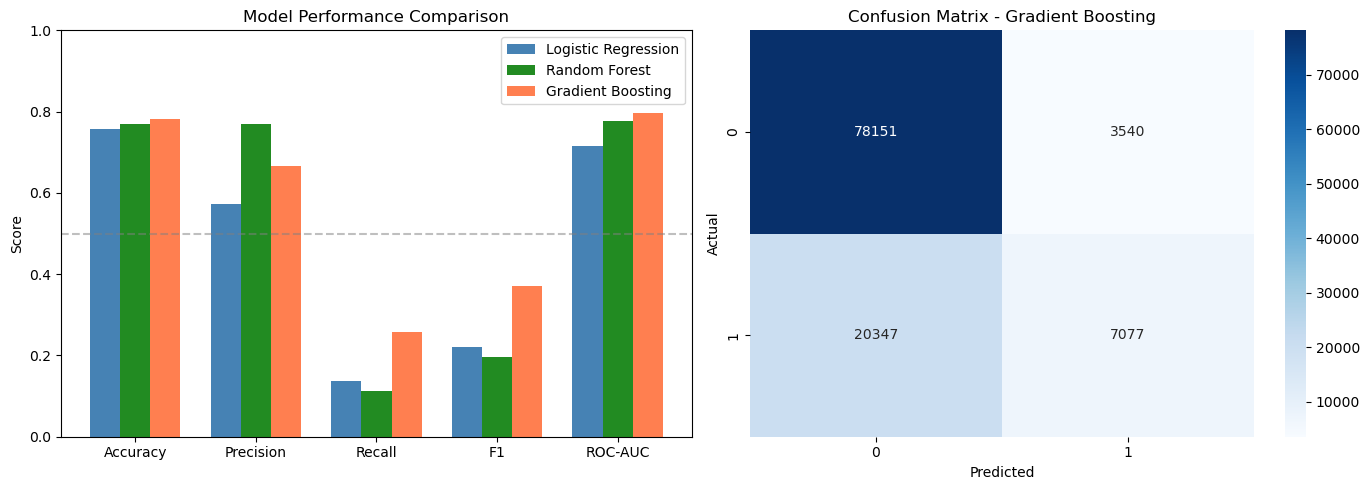

In [13]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

ax1 = axes[0]
ax1.bar(x - width, results.iloc[0][metrics].values, width, label='Logistic Regression', color='steelblue')
ax1.bar(x, results.iloc[1][metrics].values, width, label='Random Forest', color='forestgreen')
ax1.bar(x + width, results.iloc[2][metrics].values, width, label='Gradient Boosting', color='coral')

ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 1)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Best model confusion matrix
best_idx = results['ROC-AUC'].argmax()
best_preds = [y_pred_lr, y_pred_rf, y_pred_gb][best_idx]
best_name = results.iloc[best_idx]['Model']

cm = confusion_matrix(y_test_binary, best_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Confusion Matrix - {best_name}')

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

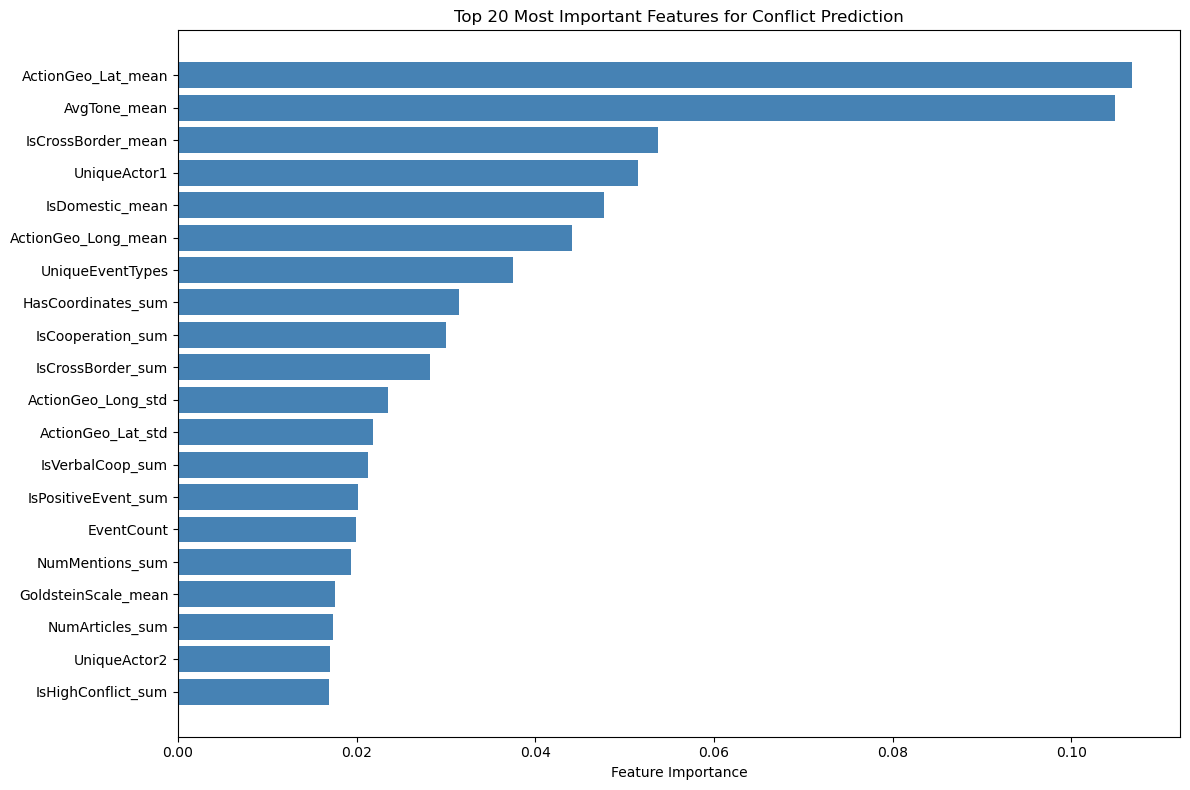


📊 Top 10 Most Important Features:
            Feature  Importance
 ActionGeo_Lat_mean    0.106838
       AvgTone_mean    0.104956
 IsCrossBorder_mean    0.053732
       UniqueActor1    0.051541
    IsDomestic_mean    0.047730
ActionGeo_Long_mean    0.044062
   UniqueEventTypes    0.037482
 HasCoordinates_sum    0.031472
  IsCooperation_sum    0.029981
  IsCrossBorder_sum    0.028205


In [14]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'].values, color='steelblue')
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features for Conflict Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 7. Regression Model: Predict Conflict Count

In [15]:
# Train regression model to predict actual conflict count
print("🔄 Training Random Forest Regressor...")
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train_reg)

y_pred_reg = rf_reg.predict(X_test)

# Metrics
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"\n📊 Regression Results (Predicting Conflict Count):")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R² Score: {r2:.4f}")
print(f"\n  Average actual conflict count: {y_test_reg.mean():.2f}")
print(f"  Average predicted: {y_pred_reg.mean():.2f}")

🔄 Training Random Forest Regressor...



📊 Regression Results (Predicting Conflict Count):
  RMSE: 274.42
  MAE: 53.17
  R² Score: 0.7103

  Average actual conflict count: 63.00
  Average predicted: 60.67


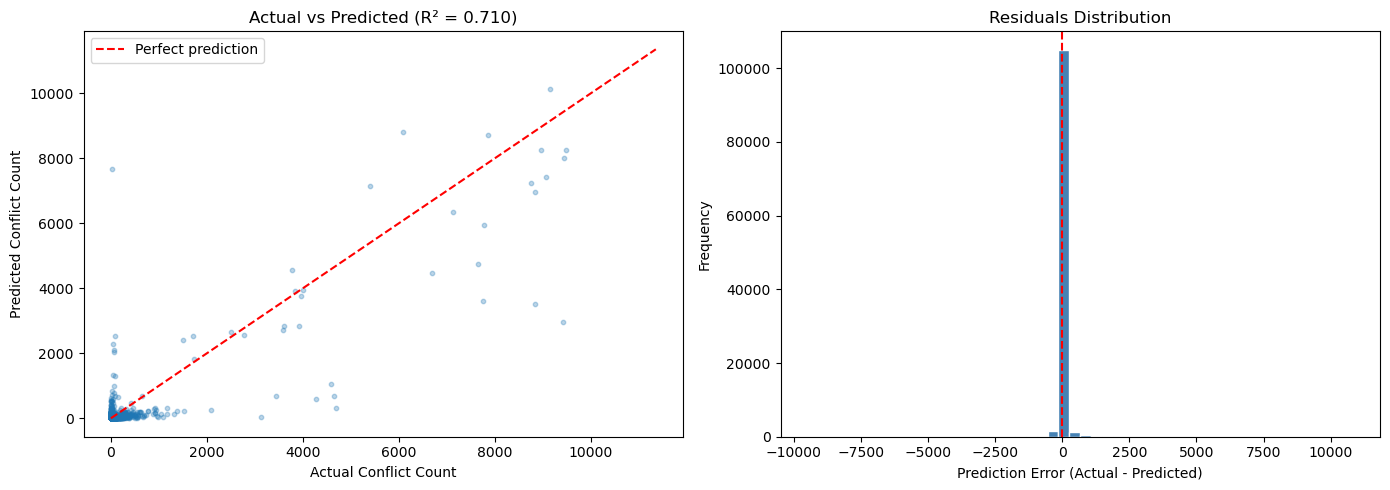

In [16]:
# Visualize regression results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
sample_size = min(5000, len(y_test_reg))
sample_idx = np.random.choice(len(y_test_reg), sample_size, replace=False)

axes[0].scatter(y_test_reg.values[sample_idx], y_pred_reg[sample_idx], alpha=0.3, s=10)
axes[0].plot([0, y_test_reg.max()], [0, y_test_reg.max()], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Conflict Count')
axes[0].set_ylabel('Predicted Conflict Count')
axes[0].set_title(f'Actual vs Predicted (R² = {r2:.3f})')
axes[0].legend()

# Residuals distribution
residuals = y_test_reg.values - y_pred_reg
axes[1].hist(residuals, bins=50, color='steelblue', edgecolor='white')
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residuals Distribution')

plt.tight_layout()
plt.show()

## 8. Escalation Prediction

In [17]:
# Train model to predict conflict escalation
print("🔄 Training Escalation Prediction Model...")
esc_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
esc_model.fit(X_train, y_train_esc)

y_pred_esc = esc_model.predict(X_test)
y_prob_esc = esc_model.predict_proba(X_test)[:, 1]

print(f"\n📊 Escalation Prediction Results:")
print(f"  Accuracy: {accuracy_score(y_test_esc, y_pred_esc)*100:.2f}%")
print(f"  Precision: {precision_score(y_test_esc, y_pred_esc)*100:.2f}%")
print(f"  Recall: {recall_score(y_test_esc, y_pred_esc)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test_esc, y_pred_esc)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test_esc, y_prob_esc)*100:.2f}%")

🔄 Training Escalation Prediction Model...



📊 Escalation Prediction Results:
  Accuracy: 73.06%
  Precision: 68.86%
  Recall: 65.09%
  F1 Score: 66.92%
  ROC-AUC: 80.08%


## 9. Summary & Conclusions

In [18]:
print("="*70)
print("📋 BASELINE MODEL TESTING SUMMARY")
print("="*70)

print(f"""
📊 DATASET:
   • Training: {len(X_train):,} samples (2023)
   • Testing: {len(X_test):,} samples (2024)
   • Features: {len(feature_cols)}

🎯 TASK 1: HIGH CONFLICT PREDICTION (Binary Classification)
   Best Model: {results.loc[results['ROC-AUC'].idxmax(), 'Model']}
   • Accuracy: {results['Accuracy'].max()*100:.2f}%
   • ROC-AUC: {results['ROC-AUC'].max()*100:.2f}%
   • F1 Score: {results['F1'].max()*100:.2f}%

🎯 TASK 2: CONFLICT COUNT PREDICTION (Regression)
   • R² Score: {r2:.4f}
   • RMSE: {rmse:.2f}
   • MAE: {mae:.2f}

🎯 TASK 3: ESCALATION PREDICTION (Binary Classification)
   • Accuracy: {accuracy_score(y_test_esc, y_pred_esc)*100:.2f}%
   • ROC-AUC: {roc_auc_score(y_test_esc, y_prob_esc)*100:.2f}%

🔑 TOP PREDICTIVE FEATURES:
""")

for i, row in feature_importance.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"""
✅ CONCLUSION:
   The dataset shows predictive signal for conflict forecasting.
   Baseline models achieve meaningful performance above random.
   Ready for more advanced modeling (XGBoost, Neural Networks, etc.)
""")
print("="*70)

📋 BASELINE MODEL TESTING SUMMARY

📊 DATASET:
   • Training: 110,963 samples (2023)
   • Testing: 109,115 samples (2024)
   • Features: 53

🎯 TASK 1: HIGH CONFLICT PREDICTION (Binary Classification)
   Best Model: Gradient Boosting
   • Accuracy: 78.11%
   • ROC-AUC: 79.70%
   • F1 Score: 37.21%

🎯 TASK 2: CONFLICT COUNT PREDICTION (Regression)
   • R² Score: 0.7103
   • RMSE: 274.42
   • MAE: 53.17

🎯 TASK 3: ESCALATION PREDICTION (Binary Classification)
   • Accuracy: 73.06%
   • ROC-AUC: 80.08%

🔑 TOP PREDICTIVE FEATURES:

   41. ActionGeo_Lat_mean: 0.1068
   47. AvgTone_mean: 0.1050
   29. IsCrossBorder_mean: 0.0537
   51. UniqueActor1: 0.0515
   31. IsDomestic_mean: 0.0477

✅ CONCLUSION:
   The dataset shows predictive signal for conflict forecasting.
   Baseline models achieve meaningful performance above random.
   Ready for more advanced modeling (XGBoost, Neural Networks, etc.)

